# **fMRI Explorer: Comprehensive Neuroimaging Analysis Pipeline**

**Overview:**

The fMRI Explorer is a powerful toolkit for analyzing functional Magnetic Resonance Imaging (fMRI) data—the gold standard for non-invasive measurement of brain activity. This project demonstrates the complete neuroimaging pipeline from raw data processing to advanced statistical analysis, making it an essential foundation for more sophisticated applications like diffusion models.

In neuroscience research, fMRI measures brain activity by detecting changes in blood oxygenation levels (the BOLD signal), which reflect neural activity. Our project provides a systematic approach to extract meaningful insights from these complex 4D datasets (3D space + time).

1: Package Installation and Setup


In [1]:
# Install required packages for neuroimaging analysis
!pip install nibabel nilearn matplotlib pandas scikit-learn

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, image, plotting, connectome
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
import pandas as pd
from sklearn.covariance import LedoitWolf
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 66.3 MB/s eta 0:00:00


2: Data Loading and Exploration

In [2]:
# Download and load the ADHD dataset from Nilearn
print("Downloading ADHD dataset...")
adhd_dataset = datasets.fetch_adhd(n_subjects=1)  # Just one subject for demonstration

# Print available keys in the dataset
print("\nAvailable keys in the ADHD dataset:")
for key in adhd_dataset.keys():
    print(f"- {key}")

# Load functional data
fmri_img = adhd_dataset.func[0]  # First functional image
confounds = adhd_dataset.confounds[0]  # Corresponding confounds file
print(f"\nfMRI data shape: {image.load_img(fmri_img).shape}")

# Get MNI template for anatomical reference (since ADHD dataset doesn't include anatomical images)
print("\nDownloading MNI template for anatomical reference...")
mni_template = datasets.fetch_icbm152_2009()
anat_img = mni_template.t1  # T1-weighted anatomical template
print(f"Anatomical reference shape: {image.load_img(anat_img).shape}")

# Display dataset information
print("\nDataset description:")
for key, value in adhd_dataset.items():
    if key not in ['func', 'confounds']:
        print(f"{key}: {value}")

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/adhd

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...

[_chunk_report_] Downloaded 25616384 of 44414948 bytes (57.7%%,    0.7s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz...

[uncompress_file] .. done.


Available keys in the ADHD dataset:
- func
- confounds
- phenotypic
- description

fMRI data shape: (61, 73, 61, 176)



[get_dataset_dir] Dataset created in /root/nilearn_data/icbm152_2009

[fetch_single_file] Downloading data from https://osf.io/7pj92/download ...

[_chunk_report_] Downloaded 22732800 of 63027871 bytes (36.1%%,    1.8s remaining)

[_chunk_report_] Downloaded 50528256 of 63027871 bytes (80.2%%,    0.5s remaining)

[fetch_single_file]  ...done. (4 seconds, 0 min)

[uncompress_file] Extracting data from /root/nilearn_data/icbm152_2009/6986d62a4af09641f8625dc5757f4796/download...

[uncompress_file] .. done.

Anatomical reference shape: (197, 233, 189)

Dataset description:
phenotypic: [('"21"', 10042, '"rest_1"', 0.0559, 0, 0.2365, 0.0922, 0., 2.2915, 1.0089, '"NYU"', 'NA', '"data_set"', 10.65, '"M"', '"0.91"', 'NA', '108', '100', '115', '2', 0, 1, 'NA', 'NA', 'NA', '""', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '59', '56', '65', 'NA', '"pass"', '""', '"pass"', '""', '""', '""', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '"pass"', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', '""', '""')]
description: .. _adhd_dataset:

ADHD dataset

Access
------
See :func:`nilearn.datasets.fetch_adhd`.

Notes
-----
Part of the 1000 Functional Connectome Project. Phenotypic
information includes: diagnostic status, dimensional ADHD symptom measures,
age, sex, intelligence quotient (IQ) and lifetime medication status.
Preliminary quality control assessments (usable vs. questionable) based upon
visual timeseries inspection are included for all :term:`resting-state` :term:`fMRI` scans.

In

3: Visualizing Raw fMRI Data

Data type: float32
Affine transform:
[[  -3.   -0.   -0.   90.]
 [  -0.    3.   -0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
Voxel dimensions (mm): (np.float32(3.0), np.float32(3.0), np.float32(3.0))
Repetition time (TR): 2.0 seconds
Number of timepoints: 176


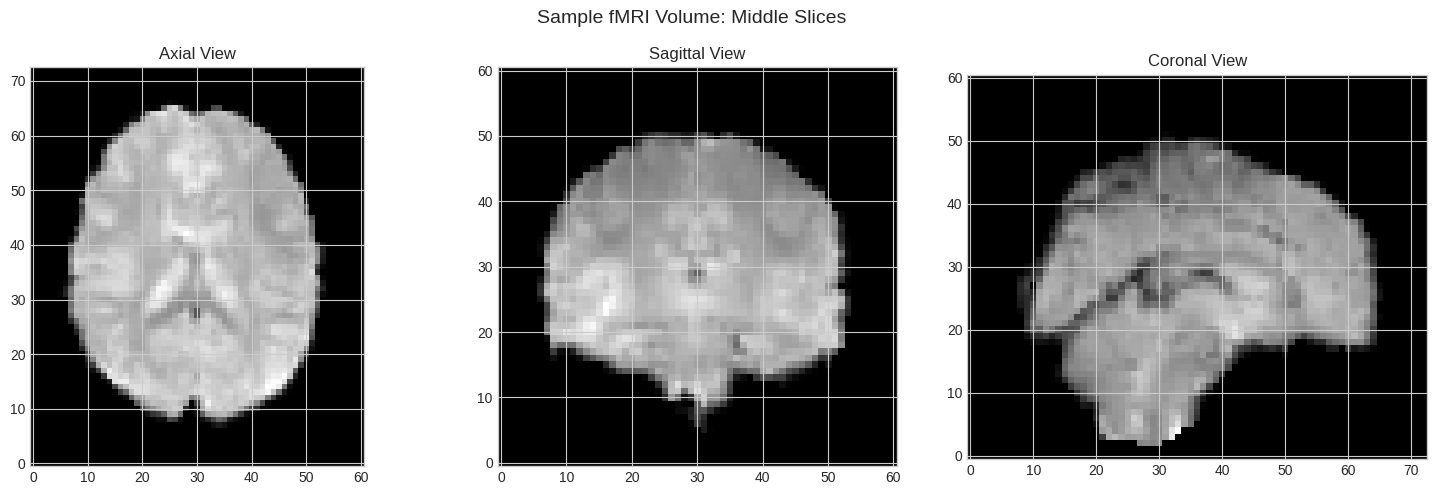

In [4]:
# Load the fMRI image and extract basic information
img = image.load_img(fmri_img)
header = img.header
affine = img.affine
single_volume = image.index_img(img, 0)  # Extract first timepoint (3D volume)

# Print image metadata
print(f"Data type: {img.get_data_dtype()}")
print(f"Affine transform:\n{affine}")
print(f"Voxel dimensions (mm): {header.get_zooms()[:3]}")
print(f"Repetition time (TR): {header.get_zooms()[3]} seconds")
print(f"Number of timepoints: {img.shape[3]}")

# Display orthogonal views of a single volume
plt.figure(figsize=(15, 5))
plt.suptitle("Sample fMRI Volume: Middle Slices", fontsize=14)

# Axial view (top-down)
plt.subplot(1, 3, 1)
plt.imshow(single_volume.get_fdata()[:, :, single_volume.shape[2]//2].T,
           cmap='gray', origin='lower')
plt.title('Axial View')

# Sagittal view (side)
plt.subplot(1, 3, 2)
plt.imshow(single_volume.get_fdata()[:, single_volume.shape[1]//2, :].T,
           cmap='gray', origin='lower')
plt.title('Sagittal View')

# Coronal view (front-back)
plt.subplot(1, 3, 3)
plt.imshow(single_volume.get_fdata()[single_volume.shape[0]//2, :, :].T,
           cmap='gray', origin='lower')
plt.title('Coronal View')

plt.tight_layout()
plt.show()

4: Preprocessing Pipeline

In [5]:
# Create a preprocessing pipeline using NiftiMasker
masker = NiftiMasker(
    # Spatial preprocessing parameters
    smoothing_fwhm=6,    # 6mm Gaussian smoothing (standard in many studies)
    standardize=True,    # Z-score normalization

    # Temporal preprocessing parameters
    high_pass=0.01,      # 0.01 Hz high-pass filter (remove slow drifts)
    low_pass=0.1,        # 0.1 Hz low-pass filter (focus on resting-state frequencies)
    t_r=2.0,             # Repetition time in seconds

    # Additional options
    detrend=True,        # Remove linear trends
    memory='nilearn_cache',  # Cache processed data
    memory_level=1,      # Cache level
    verbose=1            # Moderate verbosity
)

# Apply preprocessing and extract signal from gray matter
print("Applying preprocessing pipeline...")
fmri_preprocessed = masker.fit_transform(fmri_img, confounds=confounds)

print(f"Preprocessed data shape: {fmri_preprocessed.shape}")
print(f"Total voxels after masking: {fmri_preprocessed.shape[1]}")

Applying preprocessing pipeline...


[NiftiMasker.wrapped] Loading data from 
/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz

[NiftiMasker.wrapped] Computing the mask

________________________________________________________________________________
[Memory] Calling nilearn.masking.compute_background_mask...
compute_background_mask('/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', verbose=0)
__________________________________________compute_background_mask - 1.2s, 0.0min


[NiftiMasker.wrapped] Resampling mask

________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x79fc9e3b6890>, target_affine=None, target_shape=None, copy=False, interpolation='nearest', copy_header=True, force_resample=False)
_____________________________________________________resample_img - 0.0s, 0.0min


[NiftiMasker.wrapped] Finished fit

________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask('/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nibabel.nifti1.Nifti1Image object at 0x79fc9e3b6890>, { 'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'high_variance_confounds': False,
  'low_pass': 0.1,
  'reports': True,
  'runs': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  't_r': 2.0,
  'target_affine': None,
  'target_shape': None}, memory_level=1, memory=Memory(location=nilearn_cache/joblib), verbose=1, confounds=['/root/nilearn_data/adhd/data/0010042/0010042_regressors.csv'], sample_mask=None, copy=True, dtype=None)


[NiftiMasker.wrapped] Loading data from 
Nifti1Image('/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')

[NiftiMasker.wrapped] Smoothing images

[NiftiMasker.wrapped] Extracting region signals

[NiftiMasker.wrapped] Cleaning extracted signals

_________________________________________________filter_and_mask - 33.8s, 0.6min
Preprocessed data shape: (176, 69681)
Total voxels after masking: 69681


5: Brain Activation Visualization

Creating brain activation visualizations with color...


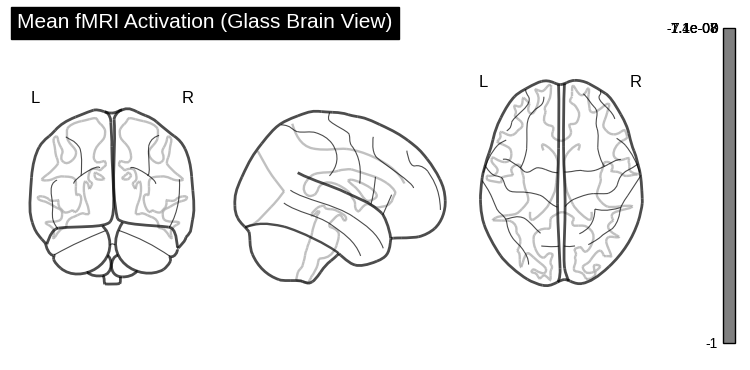

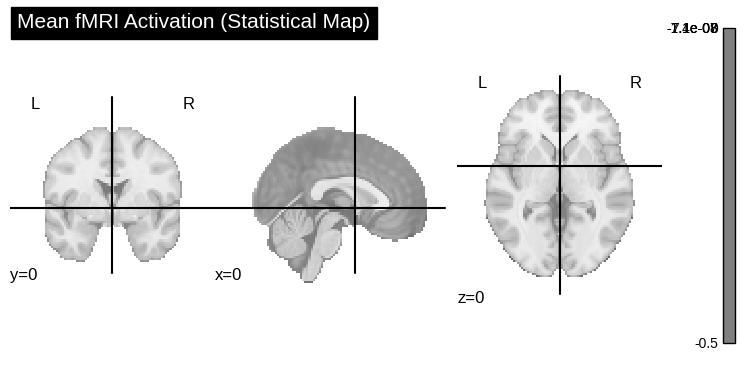

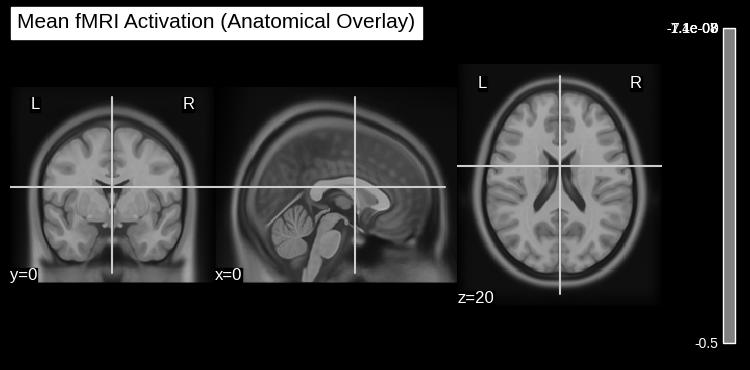

In [12]:
# Compute mean activation across time
mean_img = masker.inverse_transform(fmri_preprocessed.mean(axis=0).reshape(1, -1))

# Modified visualization code to ensure colors are displayed
print("Creating brain activation visualizations with color...")

# 1. Glass brain with explicit color settings
plotting.plot_glass_brain(
    mean_img,
    title='Mean fMRI Activation (Glass Brain View)',
    colorbar=True,
    display_mode='ortho',
    plot_abs=False,
    cmap='hot',  # Use a colormap that shows clearly on most displays
    threshold=1.0  # Set a threshold to better highlight activations
)
plt.show()

# 2. Statistical map with explicit color settings
plotting.plot_stat_map(
    mean_img,
    title='Mean fMRI Activation (Statistical Map)',
    colorbar=True,
    cut_coords=[0, 0, 0],
    cmap='RdBu_r',  # Red-Blue colormap (red for positive, blue for negative)
    threshold=0.5  # Lower threshold to ensure we see activations
)
plt.show()

# 3. Anatomical overlay with explicit color settings
plotting.plot_stat_map(
    mean_img,
    bg_img=anat_img,
    title='Mean fMRI Activation (Anatomical Overlay)',
    colorbar=True,
    cut_coords=[0, 0, 20],
    cmap='hot',  # Consistent hot colormap for better visibility
    threshold=0.5
)
plt.show()

6: ROI Analysis and Time Series Extraction

Loading Harvard-Oxford anatomical atlas...


[get_dataset_dir] Dataset created in /root/nilearn_data/fsl

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz ...

[_chunk_report_] Downloaded 17547264 of 25716861 bytes (68.2%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from /root/nilearn_data/fsl/5c734f16e50cc772ef593cab9bb3137b/HarvardOxford.tgz...

[uncompress_file] .. done.

Extracting time series from anatomical regions...


[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)

[NiftiLabelsMasker.wrapped] Resampling labels

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x79fce8d16b90>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x79fc9e3df7d0>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=['/root/nilearn_data/adhd/data/0010042/0010042_regressors.csv'], sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=1)


[NiftiLabelsMasker.wrapped] Loading data from 
/root/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

_______________________________________________filter_and_extract - 2.7s, 0.0min
Number of ROIs: 48
Time series length: 176 timepoints


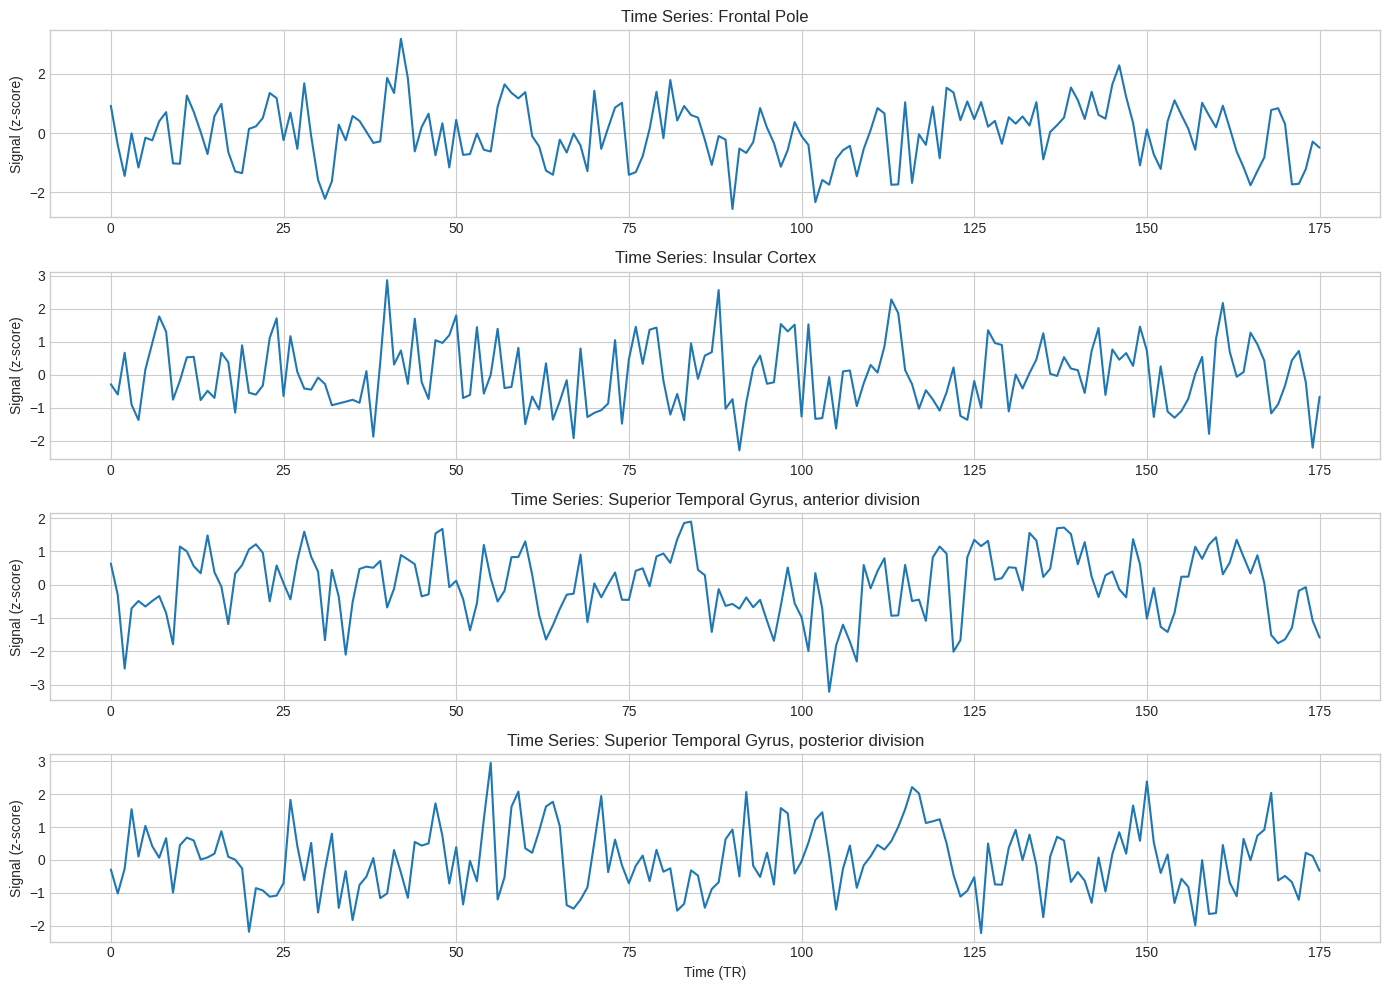

In [7]:
# Load the Harvard-Oxford atlas for region-based analysis
print("Loading Harvard-Oxford anatomical atlas...")
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps
labels = atlas.labels

# Create a masker for the atlas regions
roi_masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize=True,
    memory='nilearn_cache',
    verbose=1
)

# Extract time series from each ROI
print("Extracting time series from anatomical regions...")
roi_time_series = roi_masker.fit_transform(fmri_img, confounds=confounds)

# Display information about the extracted ROIs
print(f"Number of ROIs: {roi_time_series.shape[1]}")
print(f"Time series length: {roi_time_series.shape[0]} timepoints")

# Plot time series for key regions of interest
regions_to_plot = ['Frontal Pole', 'Insular Cortex', 'Superior Temporal Gyrus',
                   'Hippocampus', 'Thalamus']
region_indices = [i for i, label in enumerate(labels)
                 if any(region in label for region in regions_to_plot)]

plt.figure(figsize=(14, 10))
for i, idx in enumerate(region_indices):
    plt.subplot(len(region_indices), 1, i+1)
    plt.plot(roi_time_series[:, idx])
    plt.title(f"Time Series: {labels[idx]}")
    plt.ylabel("Signal (z-score)")
    if i == len(region_indices)-1:
        plt.xlabel("Time (TR)")
plt.tight_layout()
plt.show()

 7: Functional Connectivity Analysis

Computing functional connectivity matrices...
ROI time series shape: (176, 48)
Correlation matrix shape: (48, 48)


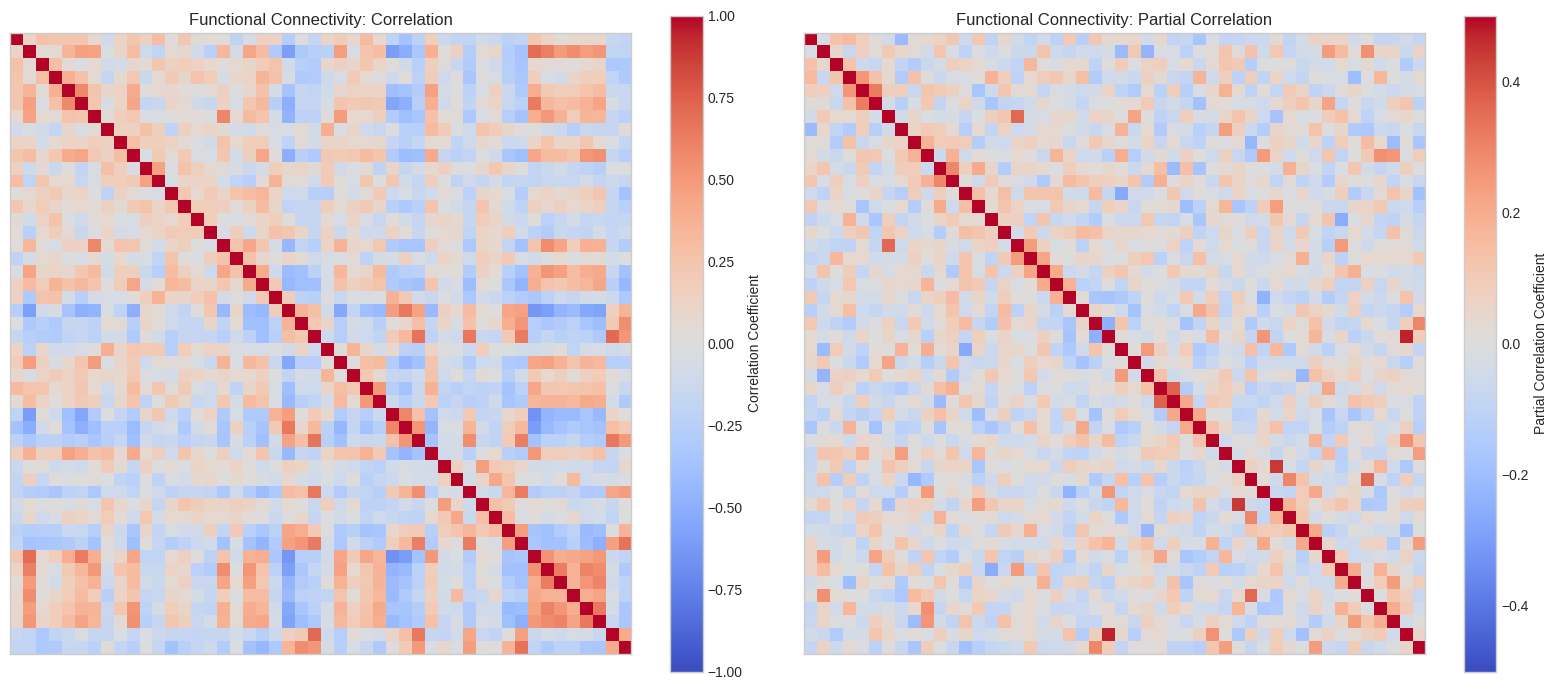

Creating 3D brain connectivity visualization...


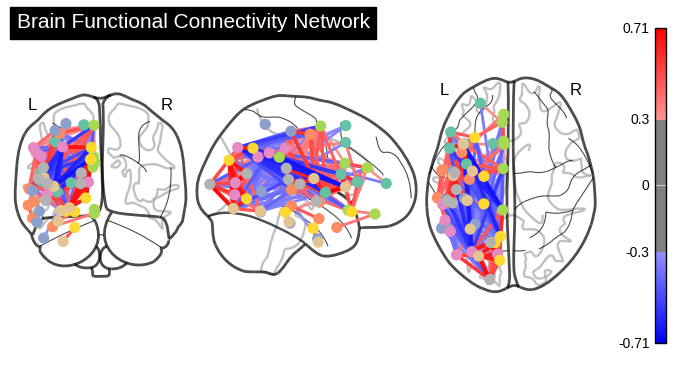

In [9]:
# Compute correlation matrix (functional connectivity)
print("Computing functional connectivity matrices...")

# Method 1: Using ConnectivityMeasure with vectorize=False to get the full matrix directly
correlation_measure = connectome.ConnectivityMeasure(
    kind='correlation',
    vectorize=False  # Return the full matrix rather than the vectorized form
)
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

# Let's verify the matrix dimensions
print(f"ROI time series shape: {roi_time_series.shape}")
print(f"Correlation matrix shape: {correlation_matrix.shape}")

# Compute partial correlation with Ledoit-Wolf regularization
# (More robust measure of direct connections)
partial_correlation_measure = connectome.ConnectivityMeasure(
    kind='partial correlation',
    vectorize=False,  # Return the full matrix
    cov_estimator=LedoitWolf()
)
partial_correlation_matrix = partial_correlation_measure.fit_transform([roi_time_series])[0]

# Plot connectivity matrices
plt.figure(figsize=(16, 7))

# Plot correlation matrix
plt.subplot(1, 2, 1)
im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation Coefficient')
plt.title('Functional Connectivity: Correlation')
plt.xticks([])
plt.yticks([])

# Plot partial correlation matrix
plt.subplot(1, 2, 2)
im = plt.imshow(partial_correlation_matrix, cmap='coolwarm', vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='Partial Correlation Coefficient')
plt.title('Functional Connectivity: Partial Correlation')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

# Create a 3D visualization of the strongest connections
print("Creating 3D brain connectivity visualization...")
# Get coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas_filename)

# Threshold connections to show only the strongest
threshold = 0.3  # Only connections with |correlation| > 0.3

# Plot connectome
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold=threshold,
    title='Brain Functional Connectivity Network',
    colorbar=True
)
plt.show()

8: Statistical Analysis with the General Linear Model (GLM)

Performing GLM statistical analysis...


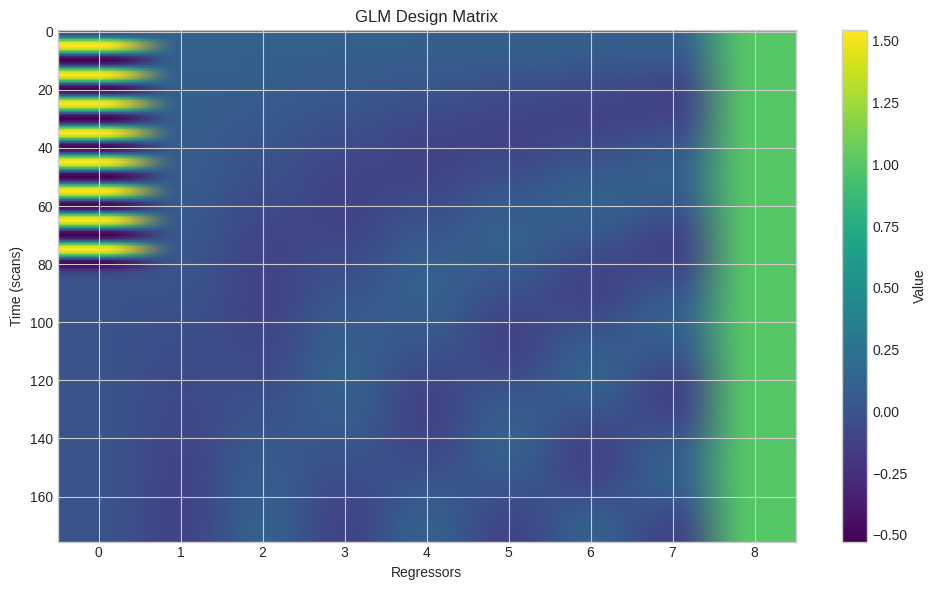

Fitting GLM model to the data...
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.08121 , ...,  0.130359],
       ...,
       [ 0.134811, ...,  0.108494]], dtype=float32), 
<nibabel.nifti1.Nifti1Image object at 0x79fc9e3b6890>)
___________________________________________________________unmask - 1.1s, 0.0min


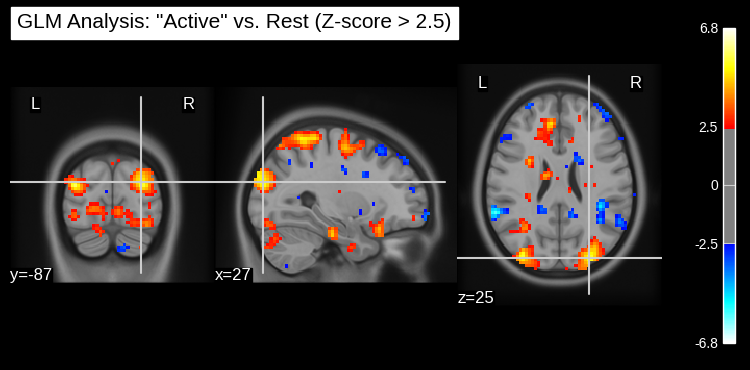

In [10]:
# For demonstration, create a simple block design
# (In real task-based fMRI, this would come from the experiment design)
print("Performing GLM statistical analysis...")
frame_times = np.arange(fmri_preprocessed.shape[0]) * 2.0  # 2s TR
block_duration = 10  # seconds
n_blocks = 8

# Create alternating blocks (e.g., task vs. rest)
onset_times = np.arange(0, n_blocks * 2 * block_duration, 2 * block_duration)

events = pd.DataFrame({
    'onset': onset_times,
    'duration': [block_duration] * len(onset_times),
    'trial_type': ['active'] * len(onset_times)
})

# Create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01
)

# Display the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='viridis')
plt.xlabel('Regressors')
plt.ylabel('Time (scans)')
plt.title('GLM Design Matrix')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

# Fit GLM model
print("Fitting GLM model to the data...")
fmri_img_4d = masker.inverse_transform(fmri_preprocessed)
glm = FirstLevelModel(
    t_r=2.0,
    mask_img=masker.mask_img_,
    minimize_memory=False,
    smoothing_fwhm=6
)
glm.fit(fmri_img_4d, design_matrices=design_matrix)

# Compute contrast (comparing active blocks to baseline)
contrast = np.zeros(design_matrix.shape[1])
contrast[0] = 1  # First column is our 'active' regressor
z_map = glm.compute_contrast(contrast, output_type='z_score')

# Plot statistical map of activation
plotting.plot_stat_map(
    z_map,
    bg_img=anat_img,
    threshold=2.5,  # z-score threshold
    title='GLM Analysis: "Active" vs. Rest (Z-score > 2.5)',
    colorbar=True
)
plt.show()

9: Advanced Visualization and Surface Mapping

Creating surface-based visualizations...


<Figure size 1200x800 with 0 Axes>

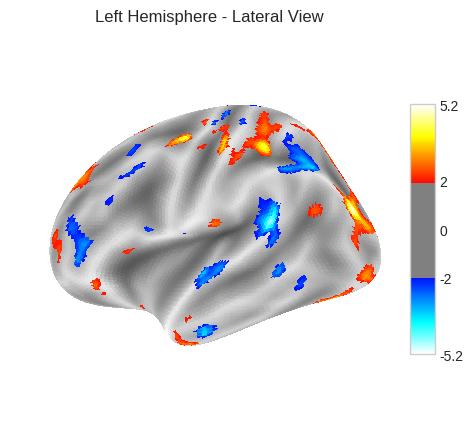

<Figure size 1200x800 with 0 Axes>

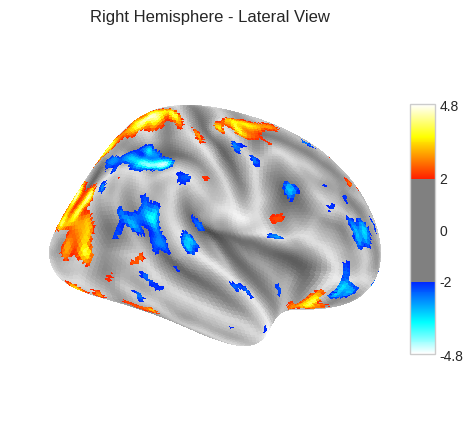

Generating interactive 3D visualization...



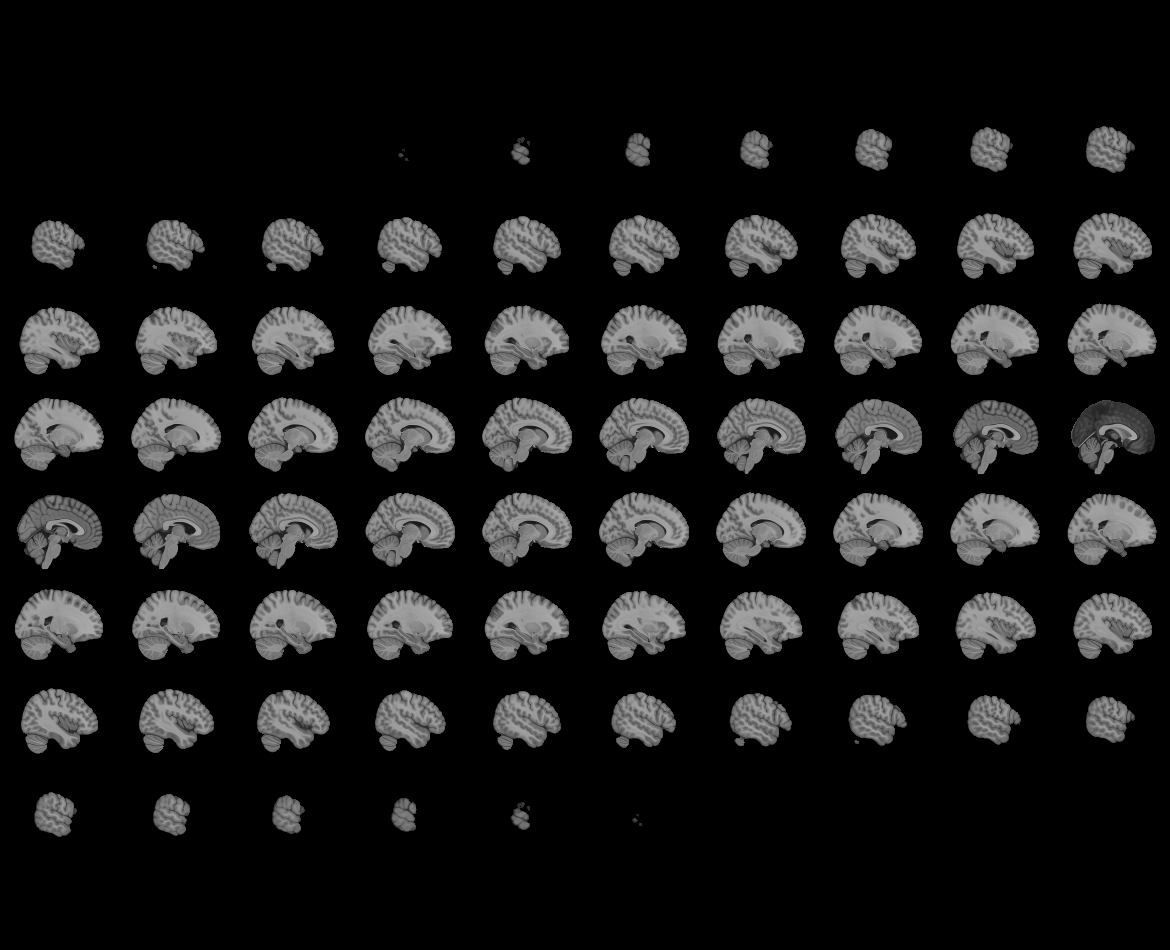
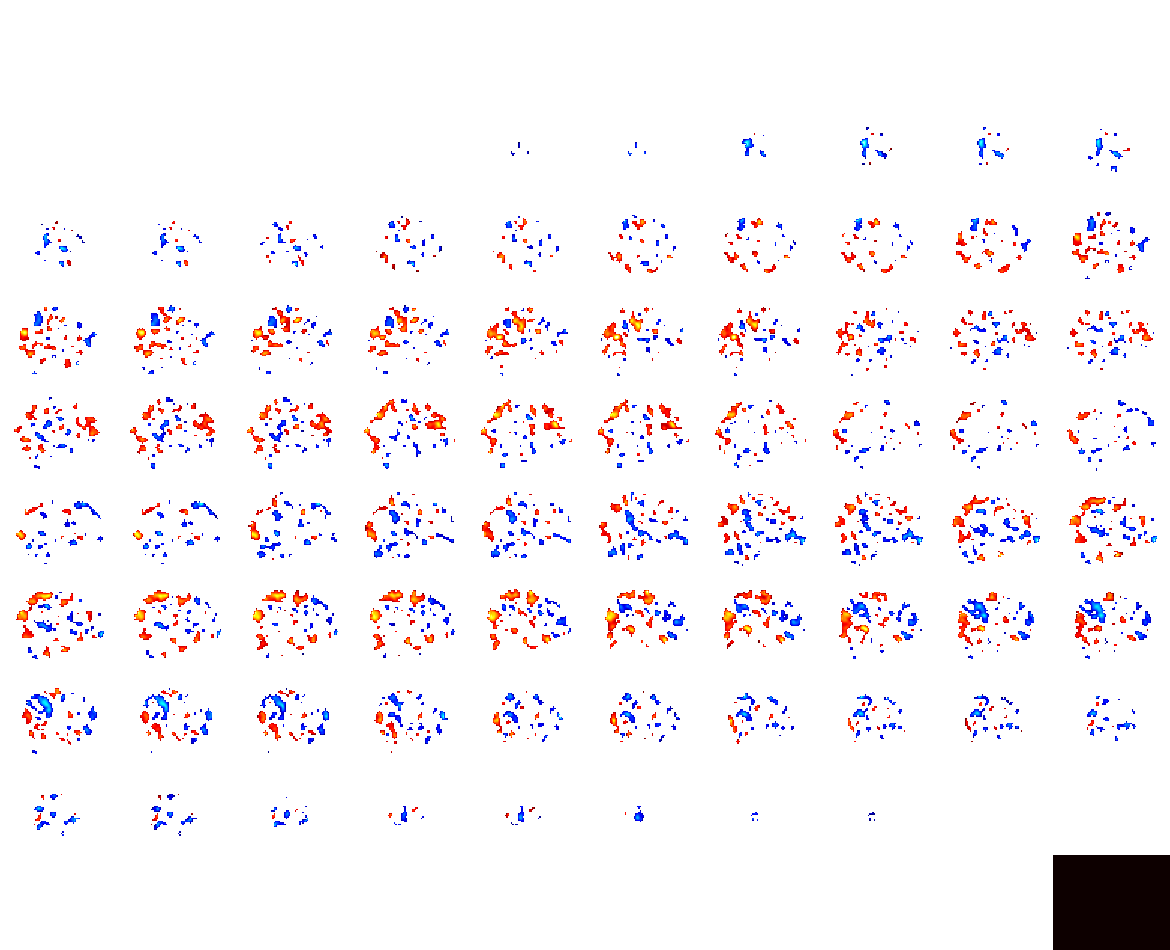

In [11]:
# Project volumetric results to cortical surface for better visualization
print("Creating surface-based visualizations...")
from nilearn import surface

# Get fsaverage surface for visualization
fsaverage = datasets.fetch_surf_fsaverage('fsaverage5')

# Project the statistical map to the surface
texture_left = surface.vol_to_surf(z_map, fsaverage.pial_left)
texture_right = surface.vol_to_surf(z_map, fsaverage.pial_right)

# Plot on inflated cortical surface
fig = plt.figure(figsize=(12, 8))
plotting.plot_surf_stat_map(
    fsaverage.infl_left,
    texture_left,
    hemi='left',
    view='lateral',
    colorbar=True,
    threshold=2.0,
    bg_map=fsaverage.sulc_left,
    title='Left Hemisphere - Lateral View'
)
plt.show()

fig = plt.figure(figsize=(12, 8))
plotting.plot_surf_stat_map(
    fsaverage.infl_right,
    texture_right,
    hemi='right',
    view='lateral',
    colorbar=True,
    threshold=2.0,
    bg_map=fsaverage.sulc_right,
    title='Right Hemisphere - Lateral View'
)
plt.show()

# Create an interactive 3D visualization
print("Generating interactive 3D visualization...")
view = plotting.view_img(
    z_map,
    threshold=2.0,
    colorbar=True,
    title='Interactive 3D Brain Activation'
)

# For Colab, create an HTML view
html_view = view._repr_html_()
from IPython.display import HTML
HTML(html_view)

# fMRI Explorer: Project Summary

This project has demonstrated a comprehensive pipeline for analyzing fMRI data, following best practices established by leading neuroimaging research centers.

**Key aspects covered:**

1. **Data Structure**: Understanding the 4D nature of fMRI data (3D volumes over time)
2. **Preprocessing**: Essential noise removal and standardization
3. **Visualization**: Multiple approaches to understand spa
tial patterns of brain activity
4. **ROI Analysis**: Region-based extraction of time series
5. **Functional Connectivity**: Analysis of brain network organization
6. **Statistical Modeling**: General Linear Model for detecting significant patterns
7. **Surface Mapping**: Advanced cortical visualization techniques

This toolkit provides a strong foundation for understanding neuroimaging data, which is essential before applying more advanced techniques like deep learning and diffusion models to fMRI data.


